In [7]:
import copy
import datetime
import hdbscan
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import re
import scipy
import shap

from collections import defaultdict
from IPython.display import display, HTML, Markdown, clear_output
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, f1_score, silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, normalize, scale
from tqdm.notebook import tqdm

In [2]:
class ClusterTransformer:
    def __init__(self):
        self.scaler = StandardScaler()

    def fit(self, X):
        self.scaler.fit(X)

    def transform(self, X):
        return scale(self.scaler.transform(X), axis=0)

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)


def convert_dataset_to_supervised(df, label_column="y"):
    pos_df = df.copy()
    neg_df = pos_df.copy()
    pos_df[label_column] = 1
    for column in neg_df.columns:
        data = neg_df[column].tolist()
        np.random.shuffle(data)
        neg_df.loc[:, column] = data
    neg_df[label_column] = 0
    return pd.concat([pos_df, neg_df])
    

def convert_education_to_ordinal(education):
    levels = {"Basic": 0, "2n Cycle": 0,
              "Graduation": 1, "Master": 1, "PhD": 1}

    return levels[education]


def get_model_with_shap_based_feature_selection(X_train, y_train, X_test, y_test, shap_probability=0.01, shap_probability_rate=0.05):
    supervised_model = GradientBoostingClassifier(n_estimators=300, max_depth=8).fit(X_train, y_train)
    
    shap_explainer = shap.TreeExplainer(supervised_model, data=X_train, model_output="probability")
    shap_test = shap_explainer(X_test).values

    threshold_rates = (np.abs(shap_test) >= shap_probability).sum(axis=0) / shap_test.shape[0]
    reduced_feature_index = threshold_rates >= shap_probability_rate

    plt.bar(x=X_train.columns, height=threshold_rates)
    plt.axhline(y=shap_probability_rate, color="r", linestyle="--")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()
    
    reduced_supervised_model = GradientBoostingClassifier(n_estimators=300, max_depth=5).fit(X_train.loc[:, reduced_feature_index], y_train)
    print("Full Model")
    print(classification_report(y_test, supervised_model.predict(X_test)))
    print("Reduced Model")
    print(classification_report(y_test, reduced_supervised_model.predict(X_test.loc[:, reduced_feature_index])))

    return reduced_supervised_model, X_train.loc[:, reduced_feature_index].columns


def get_shap_probabilities(model, background, X):
    shap_explainer = shap.TreeExplainer(model, data=background, model_output="probability")
    return shap_explainer(X).values


def get_gmm_model(X, transform=False, scaler=None):
    if transform:
        if scaler is None:
            scaler = ClusterTransformer()
            scaler.fit(X)
        X = scaler.transform(X)
    
    min_bic = float("inf")
    min_model = None

    for n_components in range(1, 10):
        clusterer = GaussianMixture(n_components=n_components, covariance_type="full").fit(X)
        bic = clusterer.bic(X)
        if bic < min_bic:
            min_model = clusterer
            min_bic = bic

    return min_model


def get_hdbscan_model(X, min_cluster_size=25, min_samples=5):
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples, prediction_data=True)
    clusterer.fit(X)
    return clusterer


def summarize_shap_clusters(model, background, X):
    shap_values = get_shap_probabilities(model, background, X)
    gmm_model = get_gmm_model(shap_values)
    hdbscan_model = get_hdbscan_model(shap_values)

    print("GMM Summary")
    print("BIC:", gmm_model.bic(shap_values))
    print("Counts:", np.unique(gmm_model.predict(shap_values), return_counts=True))
    print("Silhouette:", silhouette_score(shap_values, gmm_model.predict(shap_values)))

    print("HDBSCAN Summary")
    print("Counts:", np.unique(hdbscan.approximate_predict(hdbscan_model, shap_values)[0], return_counts=True))
    return shap_values, gmm_model, hdbscan_model

In [3]:
# Get dataset here: https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis/data
customer_df = pd.read_csv("~/Code/data/marketing_campaign.csv", sep="\t")
customer_df = customer_df.dropna().reset_index(drop=True)
customer_df["Age"] = [(datetime.date.today() - datetime.date(year=y, month=datetime.date.today().month, day=datetime.date.today().day)).days // 365 for y in customer_df["Year_Birth"]]
customer_df["CustomerAge"] = [(datetime.date.today() - datetime.datetime.strptime(d, "%d-%m-%Y").date()).days / 365 for d in customer_df["Dt_Customer"]]
customer_df["Education"] = customer_df["Education"].apply(convert_education_to_ordinal)
marital_encoder = OneHotEncoder().fit(customer_df[["Marital_Status"]])
customer_df = customer_df.join(pd.DataFrame(marital_encoder.transform(customer_df[["Marital_Status"]]).todense(), columns=[str(c) for c in marital_encoder.categories_[0]]))
customer_df.drop(columns=["ID", "Year_Birth", "Dt_Customer", "Marital_Status"], inplace=True)
features = customer_df.columns
print(customer_df.shape)

(2216, 35)


 97%|=================== | 1415/1463 [00:23<00:00]       

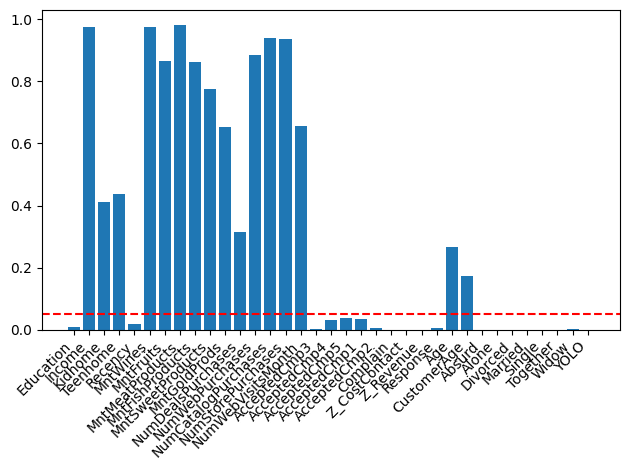

Full Model
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       732
           1       0.96      0.98      0.97       731

    accuracy                           0.97      1463
   macro avg       0.97      0.97      0.97      1463
weighted avg       0.97      0.97      0.97      1463

Reduced Model
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       732
           1       0.96      0.97      0.97       731

    accuracy                           0.97      1463
   macro avg       0.97      0.97      0.97      1463
weighted avg       0.97      0.97      0.97      1463

GMM Summary
BIC: -69773.02601543325
Counts: (array([0, 1, 2]), array([263, 352, 116]))
Silhouette: 0.14855651746223264
HDBSCAN Summary
Counts: (array([-1,  0,  1], dtype=int32), array([434, 167, 130]))


/home/mallinger/venv/ml/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/mallinger/venv/ml/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


ValueError: too many values to unpack (expected 2)

In [4]:
supervised_df = convert_dataset_to_supervised(customer_df)
supervised_train, supervised_test = train_test_split(supervised_df, test_size=0.33, stratify=supervised_df["y"])
supervised_index_test = supervised_test["y"] == 1
supervised_model, supervised_features = get_model_with_shap_based_feature_selection(supervised_train[features], supervised_train["y"], supervised_test[features], supervised_test["y"])
gmm_clusters, hdbscan_clusters = summarize_shap_clusters(supervised_model, supervised_train[supervised_features], supervised_test.loc[supervised_index_test, supervised_features])
supervised_results_df = supervised_test.loc[supervised_index_test, supervised_features].assign(gmm=gmm_clusters, hdbscan=hdbscan_clusters)
supervised_clusters_model = GradientBoostingClassifier(n_estimators=300, max_depth=5).fit(supervised_results_df[[col for col in supervised_results_df.columns if col not in ("gmm", "hdbscan")]], supervised_results_df["hdbscan"])
supervised_clusters_model_explainer = shap.KernelExplainer(supervised_clusters_model.predict_proba, shap.kmeans(supervised_results_df[[col for col in supervised_results_df.columns if col not in ("gmm", "hdbscan")]], 25))
supervised_clusters_model_explanation = supervised_clusters_model_explainer(supervised_results_df[[col for col in supervised_results_df.columns if col not in ("gmm", "hdbscan")]])
for i, class_ in enumerate(supervised_clusters_model.classes_):
    display(Markdown(f"### Class: {class_}"))
    shap.plots.beeswarm(supervised_clusters_model_explanation[:, :, i], max_display=25)

In [ ]:
customer_clusterer = hdbscan.HDBSCAN(min_cluster_size=100, min_samples=25, prediction_data=True)
customer_clusterer.fit(customer_df)

customer_clusters_model = GradientBoostingClassifier(n_estimators=300, max_depth=5).fit(customer_df[supervised_features], customer_clusterer.labels_)
customer_clusters_model_explainer = shap.KernelExplainer(customer_clusters_model.predict_proba, shap.kmeans(customer_df[supervised_features], 25))
customer_clusters_model_explanation = customer_clusters_model_explainer(customer_df[supervised_features])
for i, class_ in enumerate(customer_clusters_model.classes_):
    display(Markdown(f"### Class: {class_}"))
    shap.plots.beeswarm(customer_clusters_model_explanation[:, :, i], max_display=25)

In [ ]:
response_columns = ["AcceptedCmp1", "AcceptedCmp2", "AcceptedCmp3", "AcceptedCmp4", "AcceptedCmp5", "Response"]
response_y = customer_df[response_columns].max(axis=1).to_numpy()
response_features = [feature for feature in features if feature not in response_columns]

response_X_train, response_X_test, response_y_train, response_y_test = train_test_split(customer_df[response_features], response_y, test_size=0.33, stratify=response_y)
response_model, response_features = get_model_with_shap_based_feature_selection(response_X_train, response_y_train, response_X_test, response_y_test)
gmm_clusters, hdbscan_clusters = summarize_shap_clusters(response_model, response_X_train, response_X_test)
response_results_df = response_X_test[response_features].assign(gmm=gmm_clusters, hdbscan=hdbscan_clusters)
response_clusters_model = GradientBoostingClassifier(n_estimators=300, max_depth=5).fit(response_results_df[[col for col in response_results_df.columns if col not in ("gmm", "hdbscan")]], response_results_df["hdbscan"])
response_clusters_model_explainer = shap.KernelExplainer(response_clusters_model.predict_proba, shap.kmeans(response_results_df[[col for col in response_results_df.columns if col not in ("gmm", "hdbscan")]], 25))
response_clusters_model_explanation = response_clusters_model_explainer(response_results_df[[col for col in response_results_df.columns if col not in ("gmm", "hdbscan")]])

for i, class_ in enumerate(response_clusters_model.classes_):
    display(Markdown(f"### Class: {class_}"))
    shap.plots.beeswarm(response_clusters_model_explanation[:, :, i], max_display=25)

In [ ]:
display(pd.DataFrame(np.vstack([response_results_df["gmm"], response_y_test]).T, columns=["gmm", "response"]).groupby(by=["gmm"])["response"].mean())
display(pd.DataFrame(np.vstack([response_results_df["hdbscan"], response_y_test]).T, columns=["hdbscan", "response"]).groupby(by=["hdbscan"])["response"].mean())

In [6]:
## create persona scores and then (first?) see if they can predict NumDealsPurchases in a linear
## regression!!

plt.hist(pd.DataFrame(np.log(response_X_test["NumDealsPurchases"] + 1)).reset_index(drop=True))



NameError: name 'response_X_test' is not defined